In [44]:
import math
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [96]:
def display(img,title): 
    plt.imshow(img, cmap = plt.get_cmap('gray'))
    plt.title(title)
    plt.show()

In [78]:
def gaussianSmoothing(image):
#applies 7x7 Gaussian Mask on the Image
    imageArray = np.array(image)
    gaussianArr = np.array(image)
    sum = 0

    for i in range(3, image.shape[0] - 3):
        for j in range(3, image.shape[1] - 3):
            sum = applyGaussianFilterAtPoint(imageArray, i, j)
            gaussianArr[i][j] = sum

    return gaussianArr

In [46]:
def applyGaussianFilterAtPoint(imageData, row, column):
    sum = 0
    for i in range(row - 3, row + 4):
        for j in range(column - 3, column + 4):
            sum += gaussian_filter[i - row + 3][j - column + 3] * imageData[i][j]

    return sum

In [76]:
def getGradientX(imgArr, height, width):
    imageData = np.empty(shape=(height, width))
    for i in range(3, height - 5):
        for j in range(3, imgArr[i].size - 5):
            if liesInUnderRegion(imgArr, i, j):
                imageData[i + 1][j + 1] = None
            else:
                imageData[i + 1][j + 1] = prewittAtX(imgArr, i, j)

    return abs(imageData)


In [77]:
def getGradientY(imgArr, height, width):
    imageData = np.empty(shape=(height, width))
    for i in range(3, height - 5):
        for j in range(3, imgArr[i].size - 5):
            if liesInUnderRegion(imgArr, i, j):
                imageData[i + 1][j + 1] = None
            else:
                imageData[i + 1][j + 1] = prewittAtY(imgArr, i, j)

    return abs(imageData)


In [79]:
def getMagnitude(Gx, Gy, height, width):
    #Computes the gradient magnitude by taking square root of gx-square plus gy-square
    gradientData = np.empty(shape=(height, width))
    for row in range(height):
        for column in range(width):
            gradientData[row][column] = ((Gx[row][column] ** 2 + Gy[row][column] ** 2) ** 0.5) / 1.4142
    return gradientData

In [81]:
def getAngle(Gx, Gy, height, width):

    #Computes the edge angle by taking the tan inverse of yGradient/xGradient
    gradientData = np.empty(shape=(height, width))
    angle = 0
    for i in range(height):
        for j in range(width):
            if Gx[i][j] == 0:
                if Gy[i][j] > 0:
                    angle = 90
                else:
                    angle = -90
            else:
                angle = math.degrees(math.atan(Gy[i][j] / Gx[i][j]))
            if angle < 0:
                angle += 360
            gradientData[i][j] = angle
    return gradientData


In [82]:
def localMaximization(gradientData, gradientAngle, height, width):

    #Applies Non-Maxima suppression to gradient magnitude image
    gradient = np.empty(shape=(height, width))
    numberOfPixels = np.zeros(shape=(256))
    edgePixels = 0

    for row in range(5, height - 5):
        for col in range(5, image[row].size - 5):
            theta = gradientAngle[row, col]
            gradientAtPixel = gradientData[row, col]
            value = 0

            # Sector - 1
            if (0 <= theta <= 22.5 or 157.5 < theta <= 202.5 or 337.5 < theta <= 360):
                if gradientAtPixel > gradientData[row, col + 1] and gradientAtPixel > gradientData[row, col - 1]:
                    value = gradientAtPixel
                else:
                    value = 0

            # Sector - 2
            elif (22.5 < theta <= 67.5 or 202.5 < theta <= 247.5):
                if gradientAtPixel > gradientData[row + 1, col - 1] and gradientAtPixel > gradientData[
                    row - 1, col + 1]:
                    value = gradientAtPixel
                else:
                    value = 0

            # Sector - 3
            elif (67.5 < theta <= 112.5 or 247.5 < theta <= 292.5):
                if gradientAtPixel > gradientData[row + 1, col] and gradientAtPixel > gradientData[row - 1, col]:
                    value = gradientAtPixel
                else:
                    value = 0

            # Sector - 4
            elif 112.5 < theta <= 157.5 or 292.5 < theta <= 337.5:
                if gradientAtPixel > gradientData[row + 1, col + 1] \
                        and gradientAtPixel > gradientData[row - 1, col - 1]:
                    value = gradientAtPixel
                else:
                    value = 0

            gradient[row, col] = value

            # If value is greater than one after non maxima suppression
            if value > 0:
                edgePixels += 1
                try:
                    numberOfPixels[int(value)] += 1
                except:
                    print('Out of range gray level value', value)

    print('Number of Edge pixels:', edgePixels)
    return [gradient, numberOfPixels, edgePixels]



In [116]:
def pTile(percent, imageData, numberOfPixels, edgePixels, file):
  
    #Applies p-tile method of automatic thresholding to find the best threshold value and then apply that
    # Number of pixels to keep
    threshold = np.around(edgePixels * percent / 100)
    sum, value = 0, 255
    for value in range(255, 0, -1):
        sum += numberOfPixels[value]
        if sum >= threshold:
            break

    for i in range(imageData.shape[0]):
        for j in range(imageData[i].size):
            if imageData[i, j] < value:
                imageData[i, j] = 0
            else:
                imageData[i, j] = 255

    print('For', percent, '- result:')
    print('Total pixels after thresholding:', sum)
    print('Threshold gray level value:', value)
    plt.imshow(imageData, cmap='gray')
    cv2.imwrite(str(percent) + "_percent.bmp", imageData)


In [53]:
def liesInUnderRegion(imgArr, i, j):
    return imgArr[i][j] == None or imgArr[i][j + 1] == None or imgArr[i][j - 1] == None or imgArr[i + 1][j] == None or \
           imgArr[i + 1][j + 1] == None or imgArr[i + 1][j - 1] == None or imgArr[i - 1][j] == None or \
           imgArr[i - 1][j + 1] == None or imgArr[i - 1][j - 1] == None

In [54]:
def prewittAtX(imageData, row, column):
    sum = 0
    horizontal = 0
    for i in range(0, 3):
        for j in range(0, 3):
            horizontal += imageData[row + i, column + j] * prewittX[i, j]
    return horizontal


In [55]:
def prewittAtY(imageData, row, column):
    sum = 0
    vertical = 0
    for i in range(0, 3):
        for j in range(0, 3):
            vertical += imageData[row + i, column + j] * prewittY[i, j]
    return vertical

# **STEP 1: Calculating and Creating the Gaussian Filter and Prewitt Operator**

In [56]:
 gaussian_filter = (1.0 / 140.0) * np.array([[1, 1, 2, 2, 2, 1, 1],
                                                [1, 2, 2, 4, 2, 2, 1],
                                                [2, 2, 4, 8, 4, 2, 2],
                                                [2, 4, 8, 16, 8, 4, 2],
                                                [2, 2, 4, 8, 4, 2, 2],
                                                [1, 2, 2, 4, 2, 2, 1],
                                                [1, 1, 2, 2, 2, 1, 1]])


In [58]:
prewittX = (1.0 / 3.0) * np.array([[-1, 0, 1],
                                       [-1, 0, 1],
                                       [-1, 0, 1]])

prewittY = (1.0 / 3.0) * np.array([[1, 1, 1],
                                       [0, 0, 0],
                                       [-1, -1, -1]])


## **STEP 2: Uploading the image, Reading the image, and then proceeding to conver the image into grayscale**

In [16]:
from google.colab import files
from IPython.display import Image 

In [17]:
uploaded = files.upload()

Saving Test patterns.bmp to Test patterns.bmp
Saving House.bmp to House.bmp


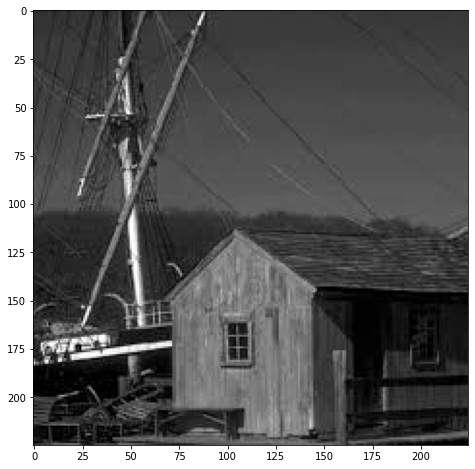

In [18]:
image = cv2.imread('House.bmp')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (8,8))
plt.imshow(gray, cmap='gray')
plt.show()

# Smoothing
We now proceed to smooth the image to reduce the intensity in the pixels

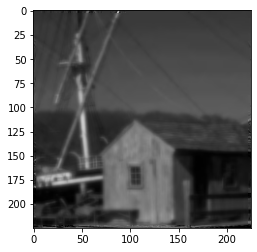

In [72]:
height = image.shape[0]
width = image.shape[1]

# Normalized Gaussian Smoothing

gaussianData = gaussianSmoothing(image)
cv2.imwrite('Outputs/filter_gauss.jpg', gaussianData)
plt.imshow(gaussianData)
plt.show()

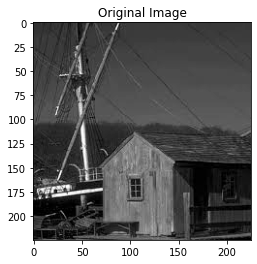

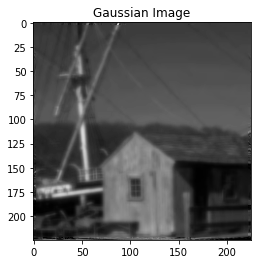

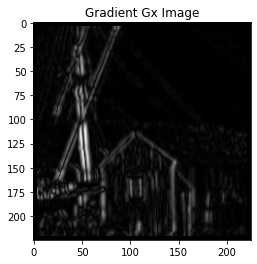

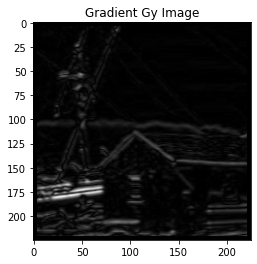

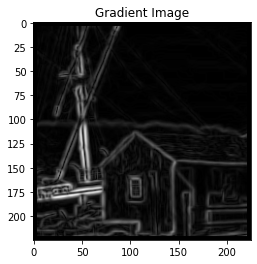

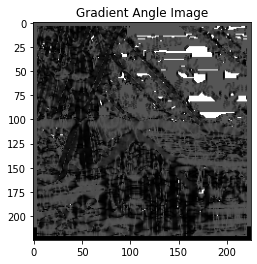

Number of Edge pixels: 9960
For 25 - result:
Total pixels after thresholding: 2611.0
Threshold gray level value: 10
For 50 - result:
Total pixels after thresholding: 5742.0
Threshold gray level value: 3
For 75 - result:
Total pixels after thresholding: 8855.0
Threshold gray level value: 1


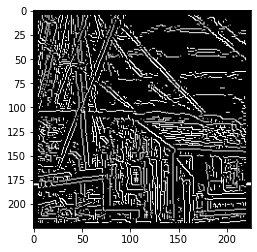

In [121]:
if __name__ == "__main__":

    gaussian_filter = (1.0 / 140.0) * np.array([[1, 1, 2, 2, 2, 1, 1],
                                                [1, 2, 2, 4, 2, 2, 1],
                                                [2, 2, 4, 8, 4, 2, 2],
                                                [2, 4, 8, 16, 8, 4, 2],
                                                [2, 2, 4, 8, 4, 2, 2],
                                                [1, 2, 2, 4, 2, 2, 1],
                                                [1, 1, 2, 2, 2, 1, 1]])

    prewittX = (1.0 / 3.0) * np.array([[-1, 0, 1],
                                       [-1, 0, 1],
                                       [-1, 0, 1]])

    prewittY = (1.0 / 3.0) * np.array([[1, 1, 1],
                                       [0, 0, 0],
                                       [-1, -1, -1]])

    # file = sys.argv[1]
    # Read Image and convert to 2D numpy array
    image = cv2.imread('House.bmp', 0)
    display(image, 'Original Image')

    height = image.shape[0]
    width = image.shape[1]

    # Normalized Gaussian Smoothing
    gaussianData = gaussianSmoothing(image)
    cv2.imwrite('filter_gauss.bmp', gaussianData)
    display(gaussianData, 'Gaussian Image')

    # Normalized Horizontal Gradient
    Gx = getGradientX(gaussianData, height, width)
    cv2.imwrite('XGradient.bmp', Gx)
    display(Gx, 'Gradient Gx Image')

    # Normalized Vertical Gradient
    Gy = getGradientY(gaussianData, height, width)
    cv2.imwrite('YGradient.bmp', Gy)
    display(Gy, 'Gradient Gy Image')

    # Normalized Edge Magnitude
    gradient = getMagnitude(Gx, Gy, height, width)
    cv2.imwrite('Gradient.bmp', gradient)
    display(gradient, 'Gradient Image')

    # Edge angle
    gradientAngle = getAngle(Gx, Gy, height, width)
    display(gradientAngle, 'Gradient Angle Image')

    # Non maxima suppression
    localMaxSuppressed = localMaximization(gradient, gradientAngle, height, width)
    imageNms = cv2.bitwise_not(localMaxSuppressed[0])
    cv2.imwrite('MaximizedImage.bmp', imageNms)

    suppressedImage = localMaxSuppressed[0]
    numberOfPixels = localMaxSuppressed[1]
    edgePixels = localMaxSuppressed[2]


    # Binary Edge image with p-tile Threshold 25%
    ptile25 = pTile(25, np.copy(suppressedImage), numberOfPixels, edgePixels, image)

    # Binary Edge image with p-tile Threshold 50%
    ptile50 = pTile(50, np.copy(suppressedImage), numberOfPixels, edgePixels, image)

    # Binary Edge image with p-tile Threshold 75%
    ptile75 = pTile(75, np.copy(suppressedImage), numberOfPixels, edgePixels, image)

## **Running the Same Program for the Second Test Image**

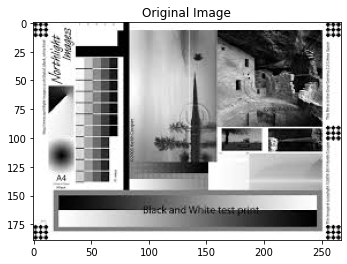

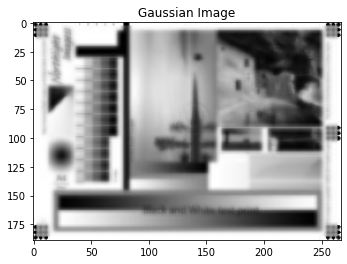

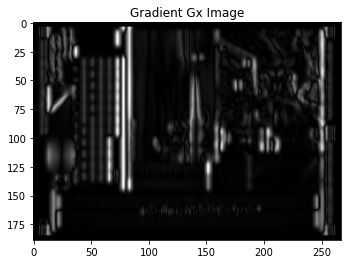

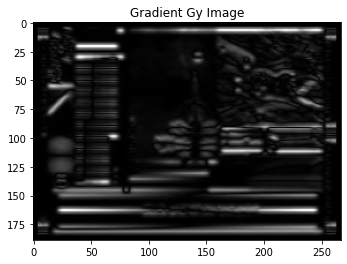

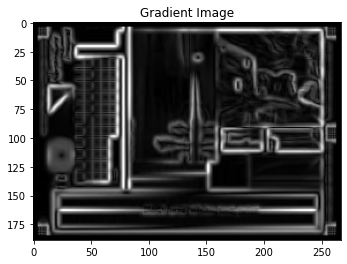

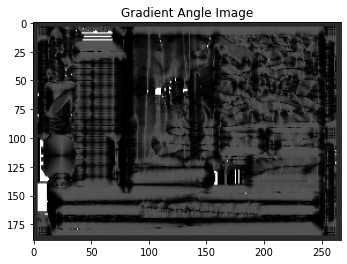

Number of Edge pixels: 8741
For 25 - result:
Total pixels after thresholding: 2218.0
Threshold gray level value: 35
For 50 - result:
Total pixels after thresholding: 4440.0
Threshold gray level value: 17
For 75 - result:
Total pixels after thresholding: 6889.0
Threshold gray level value: 5


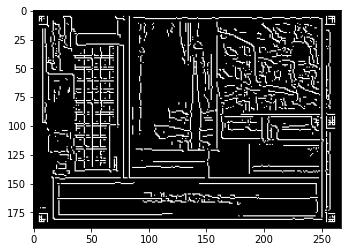

In [123]:
if __name__ == "__main__":

    gaussian_filter = (1.0 / 140.0) * np.array([[1, 1, 2, 2, 2, 1, 1],
                                                [1, 2, 2, 4, 2, 2, 1],
                                                [2, 2, 4, 8, 4, 2, 2],
                                                [2, 4, 8, 16, 8, 4, 2],
                                                [2, 2, 4, 8, 4, 2, 2],
                                                [1, 2, 2, 4, 2, 2, 1],
                                                [1, 1, 2, 2, 2, 1, 1]])

    prewittX = (1.0 / 3.0) * np.array([[-1, 0, 1],
                                       [-1, 0, 1],
                                       [-1, 0, 1]])

    prewittY = (1.0 / 3.0) * np.array([[1, 1, 1],
                                       [0, 0, 0],
                                       [-1, -1, -1]])

    # file = sys.argv[1]
    # Read Image and convert to 2D numpy array
    image = cv2.imread('Test patterns.bmp', 0)
    display(image, 'Original Image')

    height = image.shape[0]
    width = image.shape[1]

    # Normalized Gaussian Smoothing
    gaussianData = gaussianSmoothing(image)
    cv2.imwrite('filter_gauss.bmp', gaussianData)
    display(gaussianData, 'Gaussian Image')

    # Normalized Horizontal Gradient
    Gx = getGradientX(gaussianData, height, width)
    cv2.imwrite('XGradient.bmp', Gx)
    display(Gx, 'Gradient Gx Image')

    # Normalized Vertical Gradient
    Gy = getGradientY(gaussianData, height, width)
    cv2.imwrite('YGradient.bmp', Gy)
    display(Gy, 'Gradient Gy Image')

    # Normalized Edge Magnitude
    gradient = getMagnitude(Gx, Gy, height, width)
    cv2.imwrite('Gradient.bmp', gradient)
    display(gradient, 'Gradient Image')

    # Edge angle
    gradientAngle = getAngle(Gx, Gy, height, width)
    display(gradientAngle, 'Gradient Angle Image')

    # Non maxima suppression
    localMaxSuppressed = localMaximization(gradient, gradientAngle, height, width)
    imageNms = cv2.bitwise_not(localMaxSuppressed[0])
    cv2.imwrite('MaximizedImage.bmp', imageNms)

    suppressedImage = localMaxSuppressed[0]
    numberOfPixels = localMaxSuppressed[1]
    edgePixels = localMaxSuppressed[2]


    # Binary Edge image with p-tile Threshold 25%
    ptile25 = pTile(25, np.copy(suppressedImage), numberOfPixels, edgePixels, image)

    # Binary Edge image with p-tile Threshold 50%
    ptile50 = pTile(50, np.copy(suppressedImage), numberOfPixels, edgePixels, image)

    # Binary Edge image with p-tile Threshold 75%
    ptile75 = pTile(75, np.copy(suppressedImage), numberOfPixels, edgePixels, image)